In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datenspende.utils import query_ch_df, query_pg_df
import datetime
from datetime import date
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import os
import glob
from functools import reduce
import seaborn as sns

In [2]:
path = os.getcwd()+'/user_epoch/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

clean = []
csex = []
cage = []
cdf = []
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f, index_col = 0)
    if len(df['phase'].unique()) >= 4 : #and 0 in df['phase'].unique() and 1 in df['phase'].unique()
        if np.all([np.count_nonzero(df[df['phase']==ph]['hr'].notna()) > 100 for ph in df['phase'].unique()]):
                 
            cdf.append(df)
            demo_info = f.split("/")[-1].split('.')[0]
            csex.append(re.split('(\d+)',demo_info)[0])
            cage.append(int(re.split('(\d+)',demo_info)[1]))
            clean.append(int(f.split("/")[-1].split('.')[1][1:])) 

In [3]:
path = os.getcwd()+'/match_c/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

mclean = []
mcsex = []
mcage = []
mcdf = []
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f, index_col = 0)
    if len(df['phase'].unique()) >= 4: #and 0 in df['phase'].unique() and 1 in df['phase'].unique():
        if np.all([np.count_nonzero(df[df['phase']==ph]['hr'].notna()) > 100 for ph in df['phase'].unique()]):
                
                mcdf.append(df)
                demo_info = f.split("/")[-1].split('.')[0]
                
                mclean.append(int(f.split("/")[-1].split('.')[1][1:]))  
                mcsex.append(re.split('(\d+)',demo_info)[0])
                mcage.append(int(re.split('(\d+)',demo_info)[1]))

In [4]:
perss_user = pd.DataFrame(data =  np.array([clean, csex, cage]).T,columns = ['uid', 'sex', 'age'])
match_user = pd.DataFrame(data =  np.array([mclean, mcsex, mcage]).T,columns = ['uid', 'sex', 'age'])
#mu_idx = [np.where(np.array(muid) == i)[0][0] for i in [int(i) for i in match_user[(match_user.sex == 'male')&(match_user.age == '50')]['uid'].iloc[-5:].values]]
#pu_idx = np.where(np.array(uid) == int(perss_user[(perss_user.sex=='male')&(perss_user.age=='50')]['uid'].iloc[2]))[0][0]  

In [32]:
np.where(np.array(clean) == 789093)

(array([46]),)

In [33]:
pu_idx = 46

In [34]:
df = cdf[pu_idx]
df = df.sort_values('date')
df.start = pd.to_datetime(df.start)
d = df.copy()
# take out days where there is no step entry at all 
d_idx = df.groupby('date').sum()[df.groupby('date').sum()['steps'] == 0].index
df['clean'] = df['date'].apply(lambda x: 1 if x in d_idx else 0)
df = df[df['clean'] == 0]
df = df.drop('clean',axis=1)
#
d['steps'] = d['steps'].fillna(0)
d['steps'] = d['steps'] + 1

df_aggv = pd.merge(d[['start','hr','rhr', '% of MHR', 'sleep']].set_index('start').resample('60min').mean().reset_index(),d[['start','steps']].set_index('start').resample('60min').sum().reset_index(),how='outer',on='start')
d_agg = pd.merge(df_aggv, d[['start','date','day_of_week','weekend','dt','day_totest','week_totest', 'phase', 'source','id']].set_index('start').resample('60min').first().reset_index(),how='outer',on='start')

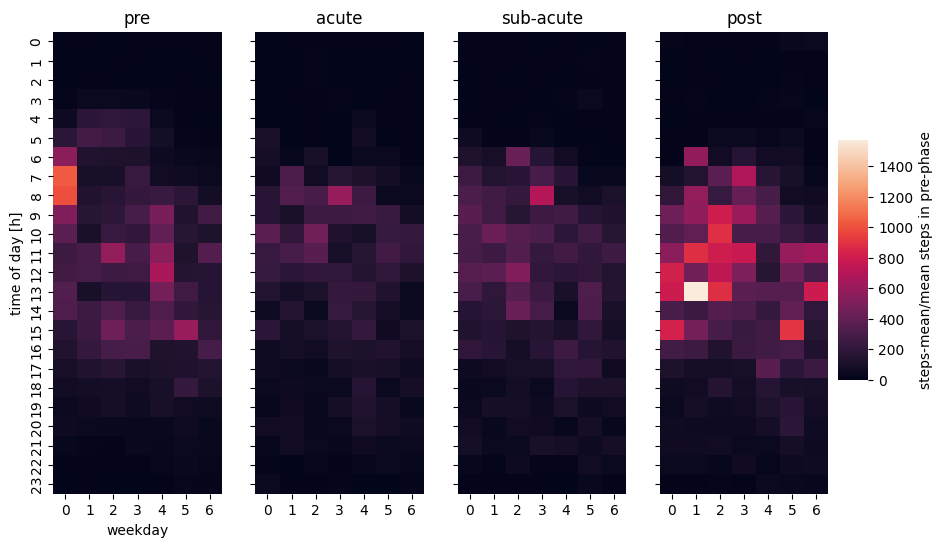

In [35]:
#d_agg['steps'] -= 4
xhd = np.zeros((24, 7,4))
for ph in range(4):
    dph = d_agg[d_agg['phase'] == ph]
    if len(dph) > 0:
        dpg = dph.groupby(by=[dph.day_of_week,dph.start.dt.time]).mean().reset_index()

        for wd in range(7):
            xhd[:,wd, ph] = dpg[dpg.day_of_week == wd]['steps'].values

xhd[xhd == 0] = np.nan
phases = ['pre', 'acute', 'sub-acute', 'post'] 
fig, axn = plt.subplots(1, 4,figsize=(10,6), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

norm = d_agg[d_agg['phase'] == 0]['steps'].mean()

for i, ax in enumerate(axn.flat): 
    sns.heatmap((xhd[:,:,i]), ax=ax, #cmap='vlag',
                cbar=i == 0,
                vmin = 0, vmax = np.nanmax(xhd),
                #vmin=-1, vmax=np.nanmax(xhd-norm)/norm,
                cbar_ax=None if i else cbar_ax,cbar_kws={'label': 'steps-mean/mean steps in pre-phase'})
    
    axn[i].set_title(phases[i])

#fig.tight_layout(rect=[0, 0, .9, 1])
axn[0].set_ylabel('time of day [h]')
axn[0].set_xlabel('weekday');
# w_pre = (xhd[:,:,0]/norm)/sum(sum(xhd[:,:,0]/norm))
# ypis = []
# for i in range(4):
#     y_pi = sum(sum(w_pre * ((xhd[:,:,i]/norm) - (xhd[:,:,0]/norm) )))
#     ypis.append(y_pi)

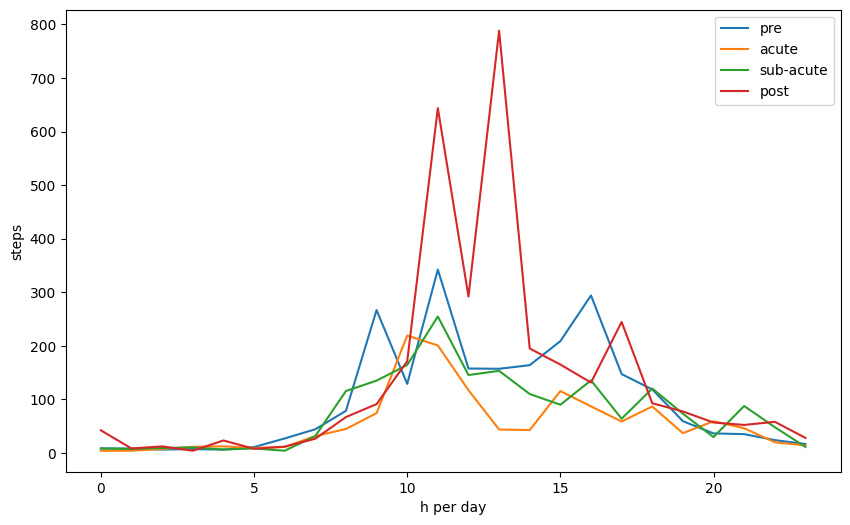

In [36]:
plt.figure(figsize=(10,6))
dw = 6
plt.plot(range(24),d_agg[(d_agg.phase == 0)&(d_agg.day_of_week == dw)].groupby(d_agg[(d_agg.phase == 0)&(d_agg.day_of_week == dw)].start.dt.time).mean().steps.values)
plt.plot(range(24),d_agg[(d_agg.phase == 1)&(d_agg.day_of_week == dw)].groupby(d_agg[(d_agg.phase == 1)&(d_agg.day_of_week == dw)].start.dt.time).mean().steps.values)
plt.plot(range(24),d_agg[(d_agg.phase == 2)&(d_agg.day_of_week == dw)].groupby(d_agg[(d_agg.phase == 2)&(d_agg.day_of_week == dw)].start.dt.time).mean().steps.values)
plt.plot(range(24),d_agg[(d_agg.phase == 3)&(d_agg.day_of_week == dw)].groupby(d_agg[(d_agg.phase == 3)&(d_agg.day_of_week == dw)].start.dt.time).mean().steps.values)
plt.xlabel('h per day')
plt.ylabel('steps')
plt.legend(phases);

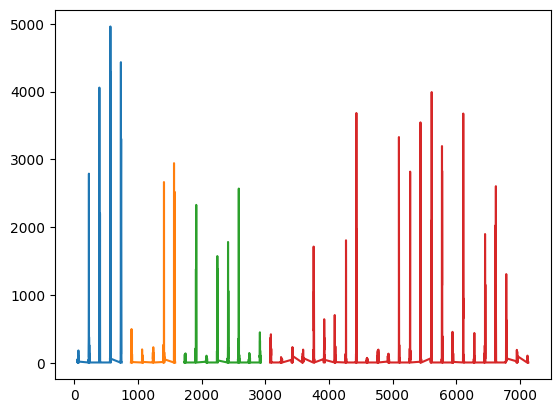

In [13]:
plt.plot(d_agg[(d_agg.phase == 0)&(d_agg.day_of_week == dw)]['steps'])
plt.plot(d_agg[(d_agg.phase == 1)&(d_agg.day_of_week == dw)]['steps'])
plt.plot(d_agg[(d_agg.phase == 2)&(d_agg.day_of_week == dw)]['steps'])
plt.plot(d_agg[(d_agg.phase == 3)&(d_agg.day_of_week == dw)]['steps'])

In [14]:
mxhds = np.zeros((24,7,4,len(mu_idx)))
i = 0
daggs  = []
for m in mu_idx:
    df = mu[m].copy()
    # ake out dates w no steps entry at all
    d_idx = df.groupby('date').sum()[df.groupby('date').sum()['steps'] == 0].index
    df['clean'] = df['date'].apply(lambda x: 1 if x in d_idx else 0)
    df = df[df['clean'] == 0]
    df = df.drop('clean',axis=1)
    #
    df = df.sort_values('date')
    df.start = pd.to_datetime(df.start)
    d = df.copy()
    d['steps'] = d['steps'].fillna(0)
    d['steps'] = d['steps'] + 1

    df_aggv = pd.merge(d[['start','hr','rhr', '% of MHR', 'sleep']].set_index('start').resample('60min').mean().reset_index(),d[['start','steps']].set_index('start').resample('60min').sum().reset_index(),how='outer',on='start')
    d_agg = pd.merge(df_aggv, d[['start','date','day_of_week','weekend','dt','day_totest','week_totest', 'phase', 'source','id']].set_index('start').resample('60min').first().reset_index(),how='outer',on='start')
    daggs.append(d_agg)
    xhd = np.zeros((24, 7,4))
    for ph in range(4):
        dph = d_agg[d_agg['phase'] == ph]
        if len(dph) > 0:
            dpg = dph.groupby(by=[dph.day_of_week,dph.start.dt.time]).mean().reset_index()
             
            for wd in range(7):
                if len(dpg[dpg.day_of_week == wd]) == 24:
                    xhd[:,wd, ph] = dpg[dpg.day_of_week == wd]['steps'].values



    norm = d_agg[d_agg['phase'] == 0]['steps'].mean()  
    xhd[xhd == 0] = np.nan
    mxhds[:,:,:, i] = xhd / norm
    i+= 1
    
mxhd = np.nanmean(mxhds,axis=3)

fig, axn = plt.subplots(1, 4,figsize=(10,6), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

 

for i, ax in enumerate(axn.flat):
    sns.heatmap((xhd[:,:,i]-norm)/norm, ax=ax, #cmap='vlag',
                cbar=i == 0,
                vmin=-1, vmax=np.nanmax(xhd -norm )/norm,
                cbar_ax=None if i else cbar_ax,cbar_kws={'label': 'steps-mean/mean steps  in pre-phase'})
    axn[i].set_title(phases[i])

w_pre = mxhd[:,:,0]/np.nansum(mxhd[:,:,0])
ypics = []    
for i in range(4):
    y_pic = np.nansum(w_pre * (mxhd[:,:,i]- mxhd[:,:,0] ))
    ypics.append(y_pic)    

NameError: name 'mu_idx' is not defined

In [13]:
ypics

[0.0, -0.935707901857954, -0.24868230843590391, -0.1724800069824518]

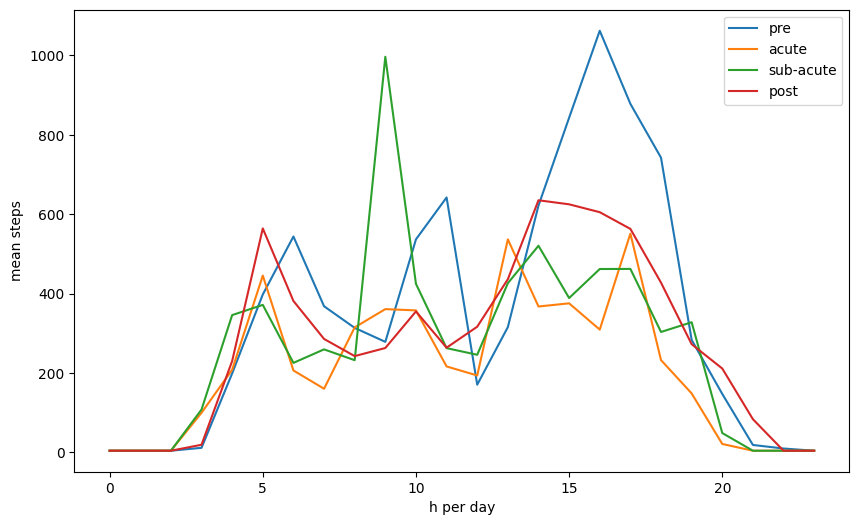

In [14]:
d_agg = daggs[1
             ]
plt.figure(figsize=(10,6))
dw = 0
plt.plot(range(24),d_agg[(d_agg.phase == 0)&(d_agg.day_of_week == dw)].groupby(d_agg[(d_agg.phase == 0)&(d_agg.day_of_week == dw)].start.dt.time).mean().steps.values)
plt.plot(range(24),d_agg[(d_agg.phase == 1)&(d_agg.day_of_week == dw)].groupby(d_agg[(d_agg.phase == 1)&(d_agg.day_of_week == dw)].start.dt.time).mean().steps.values)
plt.plot(range(24),d_agg[(d_agg.phase == 2)&(d_agg.day_of_week == dw)].groupby(d_agg[(d_agg.phase == 2)&(d_agg.day_of_week == dw)].start.dt.time).mean().steps.values)
plt.plot(range(24),d_agg[(d_agg.phase == 3)&(d_agg.day_of_week == dw)].groupby(d_agg[(d_agg.phase == 3)&(d_agg.day_of_week == dw)].start.dt.time).mean().steps.values)
plt.xlabel('h per day')
plt.ylabel('mean steps')
plt.legend(phases);

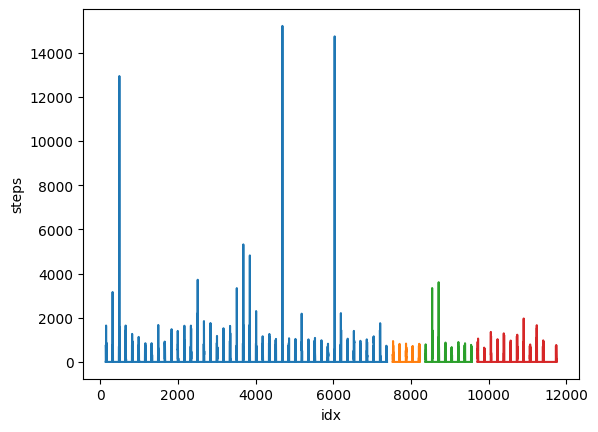

In [15]:
plt.plot(d_agg[(d_agg.phase == 0)&(d_agg.day_of_week == dw)]['steps'])
plt.plot(d_agg[(d_agg.phase == 1)&(d_agg.day_of_week == dw)]['steps'])
plt.plot(d_agg[(d_agg.phase == 2)&(d_agg.day_of_week == dw)]['steps'])
plt.plot(d_agg[(d_agg.phase == 3)&(d_agg.day_of_week == dw)]['steps'])
plt.ylabel('steps')
plt.xlabel('idx');

In [16]:
# H0 : sum y(p) - Yc(p) = 0

In [17]:
H = sum(ypis - np.array(ypics))

In [18]:
H

-2.135460961652289

In [19]:
ypis

[0.0, -1.4648723528801972, -1.2161165639098055, -0.8113422621385962]

In [20]:
ypics

[0.0, -0.935707901857954, -0.24868230843590391, -0.1724800069824518]

0.0
-0.05810622340002293
-0.009718089975700863
-0.01975523577995157


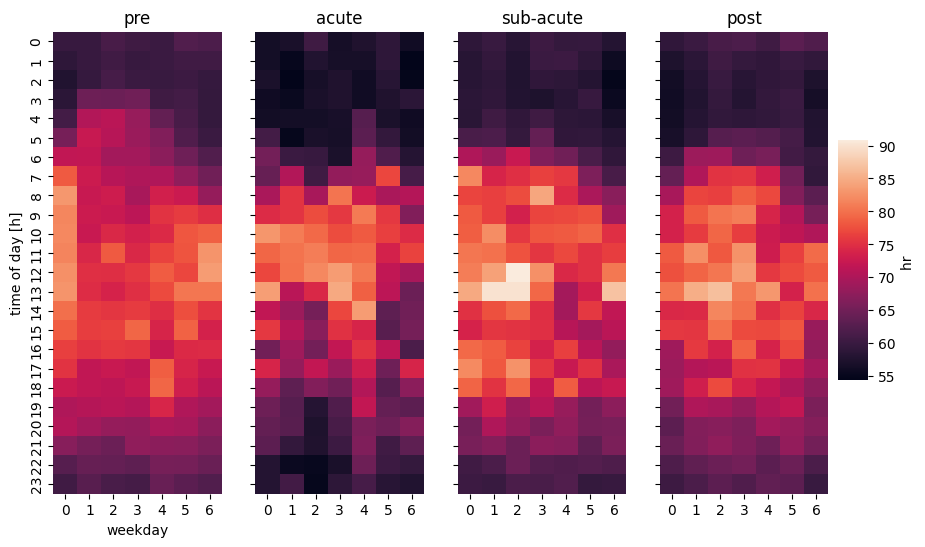

In [37]:
# for HR 
df = cdf[pu_idx]
df = df.sort_values('date')
df.start = pd.to_datetime(df.start)
d = df.copy()
d['steps'] = d['steps'].fillna(0)
d['steps'] = d['steps'] + 1

df_aggv = pd.merge(d[['start','hr','rhr', '% of MHR', 'sleep']].set_index('start').resample('60min').mean().reset_index(),d[['start','steps']].set_index('start').resample('60min').sum().reset_index(),how='outer',on='start')
d_agg = pd.merge(df_aggv, d[['start','date','day_of_week','weekend','dt','day_totest','week_totest', 'phase', 'source','id']].set_index('start').resample('60min').first().reset_index(),how='outer',on='start')

xhd = np.zeros((24, 7,4))
for ph in range(4):
    dph = d_agg[d_agg['phase'] == ph]
    dpg = dph.groupby(by=[dph.day_of_week,dph.start.dt.time]).mean().reset_index()
    
    for wd in range(7):
        xhd[:,wd, ph] = dpg[dpg.day_of_week == wd]['hr'].values
fig, axn = plt.subplots(1, 4,figsize=(10,6), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

norm = d_agg[d_agg['phase'] == 0]['hr'].mean()
xhd[xhd == 0] = np.nan
for i, ax in enumerate(axn.flat):
    sns.heatmap(xhd[:,:,i], ax=ax,
                cbar=i == 0,
                #vmin=np.nanmin(xhd)/norm, vmax=np.nanmax(xhd)/norm,
                vmin = np.nanmin(xhd), vmax = np.nanmax(xhd),
                cbar_ax=None if i else cbar_ax,cbar_kws={'label': 'hr '})
    axn[i].set_title(phases[i])

#fig.tight_layout(rect=[0, 0, .9, 1])
axn[0].set_ylabel('time of day [h]')
axn[0].set_xlabel('weekday');
w_pre = (xhd[:,:,0]/norm)/np.nansum((xhd[:,:,0]/norm))
for i in range(4):
    y_pi = np.nansum(w_pre * ((xhd[:,:,i]/norm) - (xhd[:,:,0]/norm) ))
    print(y_pi)

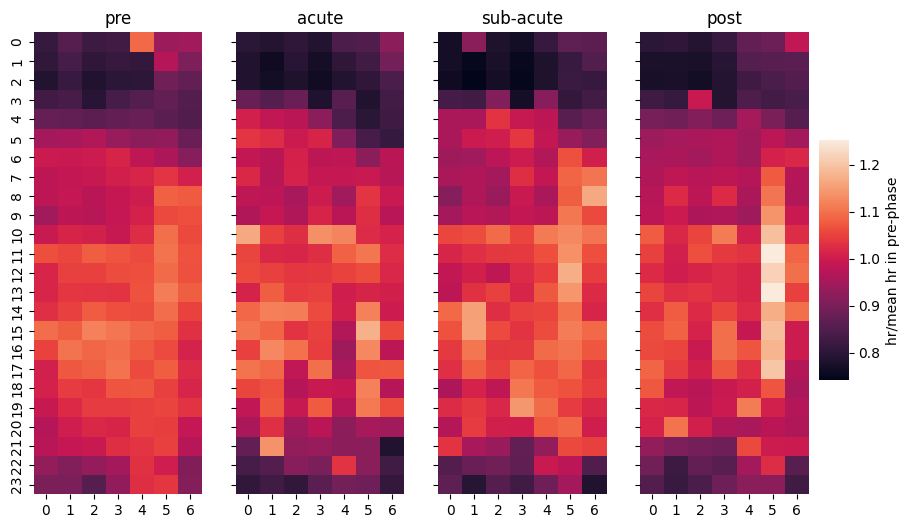

In [27]:
mxhds = np.zeros((24,7,4,len(mu_idx)))
i = 0
for m in mu_idx:
    df = mu[m].copy()
    df = df.sort_values('date')
    df.start = pd.to_datetime(df.start)
    d = df.copy()
    d['steps'] = d['steps'].fillna(0)
    d['steps'] = d['steps'] + 1

    df_aggv = pd.merge(d[['start','hr','rhr', '% of MHR', 'sleep']].set_index('start').resample('60min').mean().reset_index(),d[['start','steps']].set_index('start').resample('60min').sum().reset_index(),how='outer',on='start')
    d_agg = pd.merge(df_aggv, d[['start','date','day_of_week','weekend','dt','day_totest','week_totest', 'phase', 'source','id']].set_index('start').resample('60min').first().reset_index(),how='outer',on='start')

    xhd = np.zeros((24, 7,4))
    for ph in range(4):
        dph = d_agg[d_agg['phase'] == ph]
        if len(dph) > 0:
            dpg = dph.groupby(by=[dph.day_of_week,dph.start.dt.time]).mean().reset_index()

            for wd in range(7):
                if len(dpg[dpg.day_of_week == wd]) == 24:
                    xhd[:,wd, ph] = dpg[dpg.day_of_week == wd]['hr'].values


    xhd[xhd == 0] = np.nan
    norm = d_agg[d_agg['phase'] == 0]['hr'].mean()
    mxhds[:,:,:, i] = xhd / norm
    i+= 1
    
mxhd = np.nanmean(mxhds,axis=3) 

fig, axn = plt.subplots(1, 4,figsize=(10,6), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

 

for i, ax in enumerate(axn.flat):
    sns.heatmap(mxhd[:,:,i] , ax=ax,
                cbar=i == 0,
                vmin=np.nanmin(mxhd), vmax=np.nanmax(mxhd) ,
                cbar_ax=None if i else cbar_ax,cbar_kws={'label': 'hr/mean hr in pre-phase'})
    axn[i].set_title(phases[i])

w_pre = mxhd[:,:,0]/np.nansum(mxhd[:,:,0])
ypics = []    
for i in range(4):
    y_pic = np.nansum(w_pre * (mxhd[:,:,i]- mxhd[:,:,0] ))
    ypics.append(y_pic)    

In [25]:
ypics

[0.0, -0.021101914270802463, -0.00678910584060877, -0.012843992979122322]